In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Intro to QUA

This notebook will show you the basics of how to play and mainpulate pulses using QUA. 

We don't go into all the details, and try to just get you playing pulses as quickly is possible. 

We begin by importing the usual suspects: numpy and matplotlib. In addition, we also bring the QUA packages into the party

In [1]:
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.qua import *
from qm import SimulationConfig
import numpy as np
import matplotlib.pyplot as plt

## Configuration

Our next step is the introduce the quantum machine configuration. This dictionary defines how our experiment is set up. 
For example, here we specify which physical outputs are connected to which parts of our system. We also describe the pulses the system will generate and can describe many more parameters. 

Observe the following section of the config. It defines the _elements_ we connect the OPX to:

```python
  
        "qe1": {
            "singleInput": {"port": ("con1", 1)},
            "intermediate_frequency": 5e6,
            "operations": {
                "playOp": "constPulse",
            },
        },
  

```

This snipped defines a single _Quantum Element_, called ```"qe1"```. This is the name we give the device connected some port of the OPX, in this case: port number 1.
This element is set with a numerically controlled oscillator frequency of 5 MHz. We refer to this as the intermediate frequency (IF) as it is often used to control a higher frequency sent to the experiment using a mixer. 

The full configuration is shown below, you can skim over it for now. No need to read every row.


In [2]:
config = {
    "version": 1,
    "controllers": {
        "con1": {
            "type": "opx1",
            "analog_outputs": {
                1: {"offset": +0.0},
                2: {"offset": +0.0},
            },
        }
    },
    "elements": {
        "qe1": {
            "singleInput": {"port": ("con1", 1)},
            "intermediate_frequency": 5e6,
            "operations": {
                "playOp": "constPulse",
            },
        },
        "qe2": {
            "singleInput": {"port": ("con1", 2)},
            "intermediate_frequency": 5e6,
            "operations": {
                "playOp": "constPulse",
            },
        },
    },
    "pulses": {
        "constPulse": {
            "operation": "control",
            "length": 1000,  # in ns
            "waveforms": {"single": "const_wf"},
        },
    },
    "waveforms": {
        "const_wf": {"type": "constant", "sample": 0.2},
    },
}


## Hello QUA

We now write our first QUA program. It is defined inside a _context manager_, which is the python construct starting with the `with` keyword. 

After this context is exited, the program is saved in the `prog` variable.

In [3]:
with program() as prog:
    play("playOp", "qe1")


All that is left is to open a connection to the OPX, specifying the configuration, and then to run the program. 

We do this with the help of the **OPX simulator**. 

This is a feature that allows the output of the device to be calculated in a cycle-accurate way even if we don't have access to the OPX (for example if someone else is using it at the moment).

To use the simulator we need to pass the `simulate` method a `SimulationConfig`, which tells the simulator the number of clock cycles it needs to run.

2021-04-05 10:52:05,673 - qm - INFO - Performing health check
2021-04-05 10:52:05,731 - qm - INFO - Health check passed
2021-04-05 10:52:05,833 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-05 10:52:05,875 - qm - INFO - Flags: 
2021-04-05 10:52:05,877 - qm - INFO - Simulating Qua program


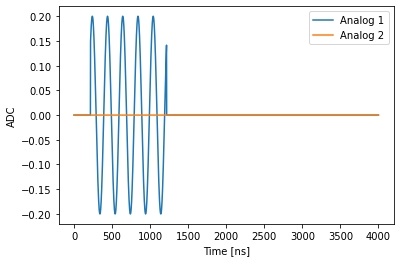

In [4]:
QMm = QuantumMachinesManager()
QMm.close_all_quantum_machines()

QM1 = QMm.open_qm(config)
job = QM1.simulate(prog, SimulationConfig(int(1000)))  # in clock cycles, 4 ns

samples = job.get_simulated_samples()
samples.con1.plot()



## Parametric pulses

The waveform generation of the OPX
You can set the amplitude, duration, frequency and many other things of the played pulse

2021-03-29 23:27:49,061 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-03-29 23:27:49,071 - qm - INFO - Flags: 
2021-03-29 23:27:49,072 - qm - INFO - Simulating Qua program


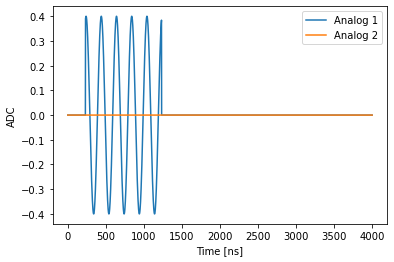

In [7]:
with program() as prog2:
    play("playOp"*amp(2), "qe1")


job = QM1.simulate(prog2, SimulationConfig(int(1000)))  # in clock cycles, 4 ns

samples = job.get_simulated_samples()
samples.con1.plot()


2021-03-29 23:27:49,520 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-03-29 23:27:49,567 - qm - INFO - Flags: 
2021-03-29 23:27:49,568 - qm - INFO - Simulating Qua program


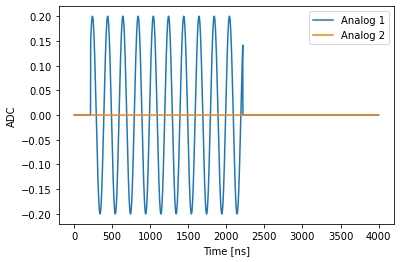

In [8]:
with program() as prog3:
    play("playOp", "qe1",duration=500)

job = QM1.simulate(prog3, SimulationConfig(int(1000)))  # in clock cycles, 4 ns

samples = job.get_simulated_samples()
samples.con1.plot()



2021-03-29 23:27:50,391 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-03-29 23:27:50,400 - qm - INFO - Flags: 
2021-03-29 23:27:50,402 - qm - INFO - Simulating Qua program


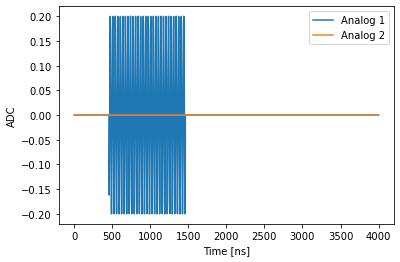

In [9]:
with program() as prog4:
    update_frequency("qe1",30e6)
    play("playOp", "qe1")

job = QM1.simulate(prog4, SimulationConfig(int(1000)))  # in clock cycles, 4 ns

samples4 = job.get_simulated_samples()
samples4.con1.plot()

We can also set the frequency without running a program using the QM API. For example, let's set the frequency back to 10 MHz and run our original program again:

2021-03-29 23:27:51,360 - qm - WARNING - set_frequency(..) is deprecated. use set_intermediate_frequency(..) instead
2021-03-29 23:27:51,369 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-03-29 23:27:51,380 - qm - INFO - Flags: 
2021-03-29 23:27:51,381 - qm - INFO - Simulating Qua program


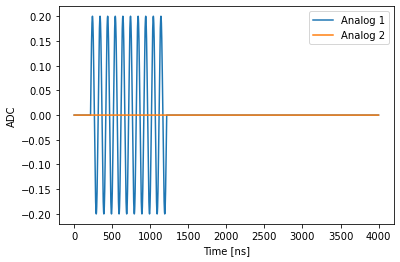

In [10]:
QM1.set_frequency("qe1",10e6)

job = QM1.simulate(prog, SimulationConfig(int(1000)))  # in clock cycles, 4 ns

samples2 = job.get_simulated_samples()
samples2.con1.plot()



# Pulses on multiple elements

By default, when playing pulses to multiple elements connected to different ports they play simultaneously as is the case in the following program

2021-03-29 23:27:52,864 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-03-29 23:27:52,873 - qm - INFO - Flags: 
2021-03-29 23:27:52,875 - qm - INFO - Simulating Qua program


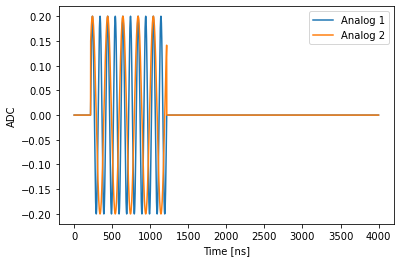

In [11]:
with program() as prog_2qe:
    play("playOp", "qe1")
    play("playOp", "qe2")


job = QM1.simulate(prog_2qe, SimulationConfig(int(1000)))  # in clock cycles, 4 ns

samples = job.get_simulated_samples()
samples.con1.plot()


We can delay one pulse relative another using the `wait` command:

2021-03-29 23:27:54,224 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-03-29 23:27:54,234 - qm - INFO - Flags: 
2021-03-29 23:27:54,236 - qm - INFO - Simulating Qua program


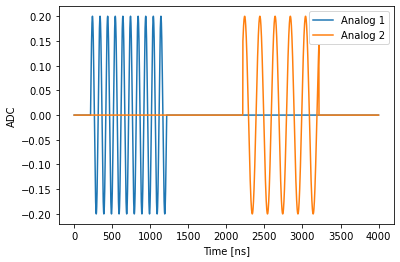

In [12]:
with program() as prog_2qe:
    play("playOp", "qe1")
    wait(500,"qe2")
    play("playOp", "qe2")


job = QM1.simulate(prog_2qe, SimulationConfig(int(1000)))  # in clock cycles, 4 ns

samples = job.get_simulated_samples()
samples.con1.plot()


But what if you don't know how long the first pulse is? maybe it's been stretched by some evil doer who didn't tell you about it? 

It doesn't matter! you can ask QUA to align the pulses one after the other

2021-03-29 23:27:55,411 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-03-29 23:27:55,419 - qm - INFO - Flags: 
2021-03-29 23:27:55,420 - qm - INFO - Simulating Qua program


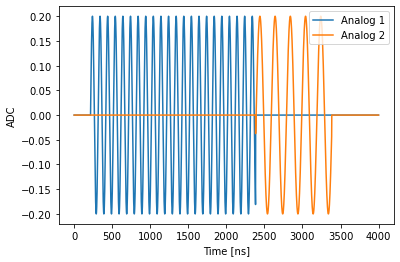

In [13]:
with program() as prog_2qe:
    play("playOp", "qe1",duration=542)
    align("qe1","qe2")
    play("playOp", "qe2")


job = QM1.simulate(prog_2qe, SimulationConfig(int(1000)))  # in clock cycles, 4 ns

samples = job.get_simulated_samples()
samples.con1.plot()


## Arbitrary waveforms

So far, we've only played pulses with a constant envelope. Note that in this case, regardless of the pulse duration, there isn't any upload of a waveform to the device memory. 
Even if the signal is a sine wave at 350 MHz, the hardware synthesizes it and there is no need for precalculation. 

However, QUA is not limited to a fixed amplitude. You can define an arbitrary envelope function with 1ns resolution. You can also change (lower) the tempoarl resolution, but that's a topic for another time. 

Below, we edit the configuration to add an arbitrary pulse. To do so we add a `pulse` and a `waveform` to the `config` dictionary.

---
**Note**

the waveform must be a python list (and not a numpy array) and that the `length` field of the pulse must match the number of `samples` in the waveform.

---


In [14]:
config['pulses']["arbPulse"]= {"operation": "control","length": 4000, "waveforms": {"single": "arb_wf"}}
config['waveforms']["arb_wf"]={"type": "arbitrary", "samples": (0.2*np.sin(np.linspace(0,10,4000))).tolist()}
QMm.close_all_quantum_machines()
QM1 = QMm.open_qm(config)

Ater changing the configuration, we had to re-open the quantum machine instance.
We can now play our pulse


2021-03-29 23:27:57,928 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-03-29 23:27:57,958 - qm - INFO - Flags: 
2021-03-29 23:27:57,958 - qm - INFO - Simulating Qua program
2021-03-29 23:27:58,041 - qm - WARNING - pulse 'arbPulse' used in play is not part of element 'qe1' operations


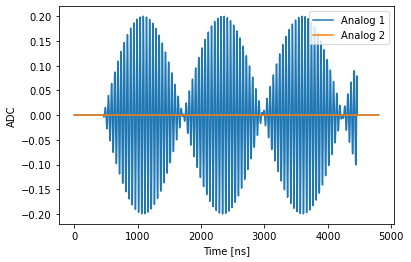

In [15]:
with program() as arbProg:
    update_frequency("qe1",20e6)
    play("arbPulse", "qe1")
job = QM1.simulate(arbProg, SimulationConfig(int(1200)))  # in clock cycles, 4 ns
samples = job.get_simulated_samples()
samples.con1.plot()


## Excercises

1. Play a rectangular pulse with no oscillations.
2. Use the [docs](https://qm-docs.s3.amazonaws.com/v0.8/python/features.html?highlight=ramp#ramp-pulse) to learn how to play a ramp pulse, and play a ramp with intermediate freq. (IF) = 0 to qe1 and IF!=0 to qe2
3. Use the arbitrary waveforms `top_wf` and `bottom_wf` defined in `wf_ex1` to add two pulses playing them respectively. Then play top to `qe1` and bottom to `qe2`. You may want to use DC on both channels and stretch the pulses to 1000 cycles to get a good view of the result. This question demonstrates the ability of QUA to stretch arbitrary waveforms too, and not just fixed amplitude signals. 
